In [1]:
import random
import numpy as np
import torch
import torchvision
from sklearn.base import BaseEstimator, ClassifierMixin
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt

In [3]:
data_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    lambda x: torch.floor(x * 255 / 128).squeeze(dim=0)])

In [4]:
def get_data(data, indices=None, binarize=True):
    N = len(data)
    if indices is None:
        indices = range(0, N)
        X = torch.stack([data[i][0] for i in indices], dim=0)
        y = torch.tensor([data[i][1] for i in indices])
        return X, y

In [5]:
data = datasets.EMNIST(
    root="~/data",
    split="balanced",
    download=True,
    transform=data_transform)

/opt/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
X, Y = get_data(data)

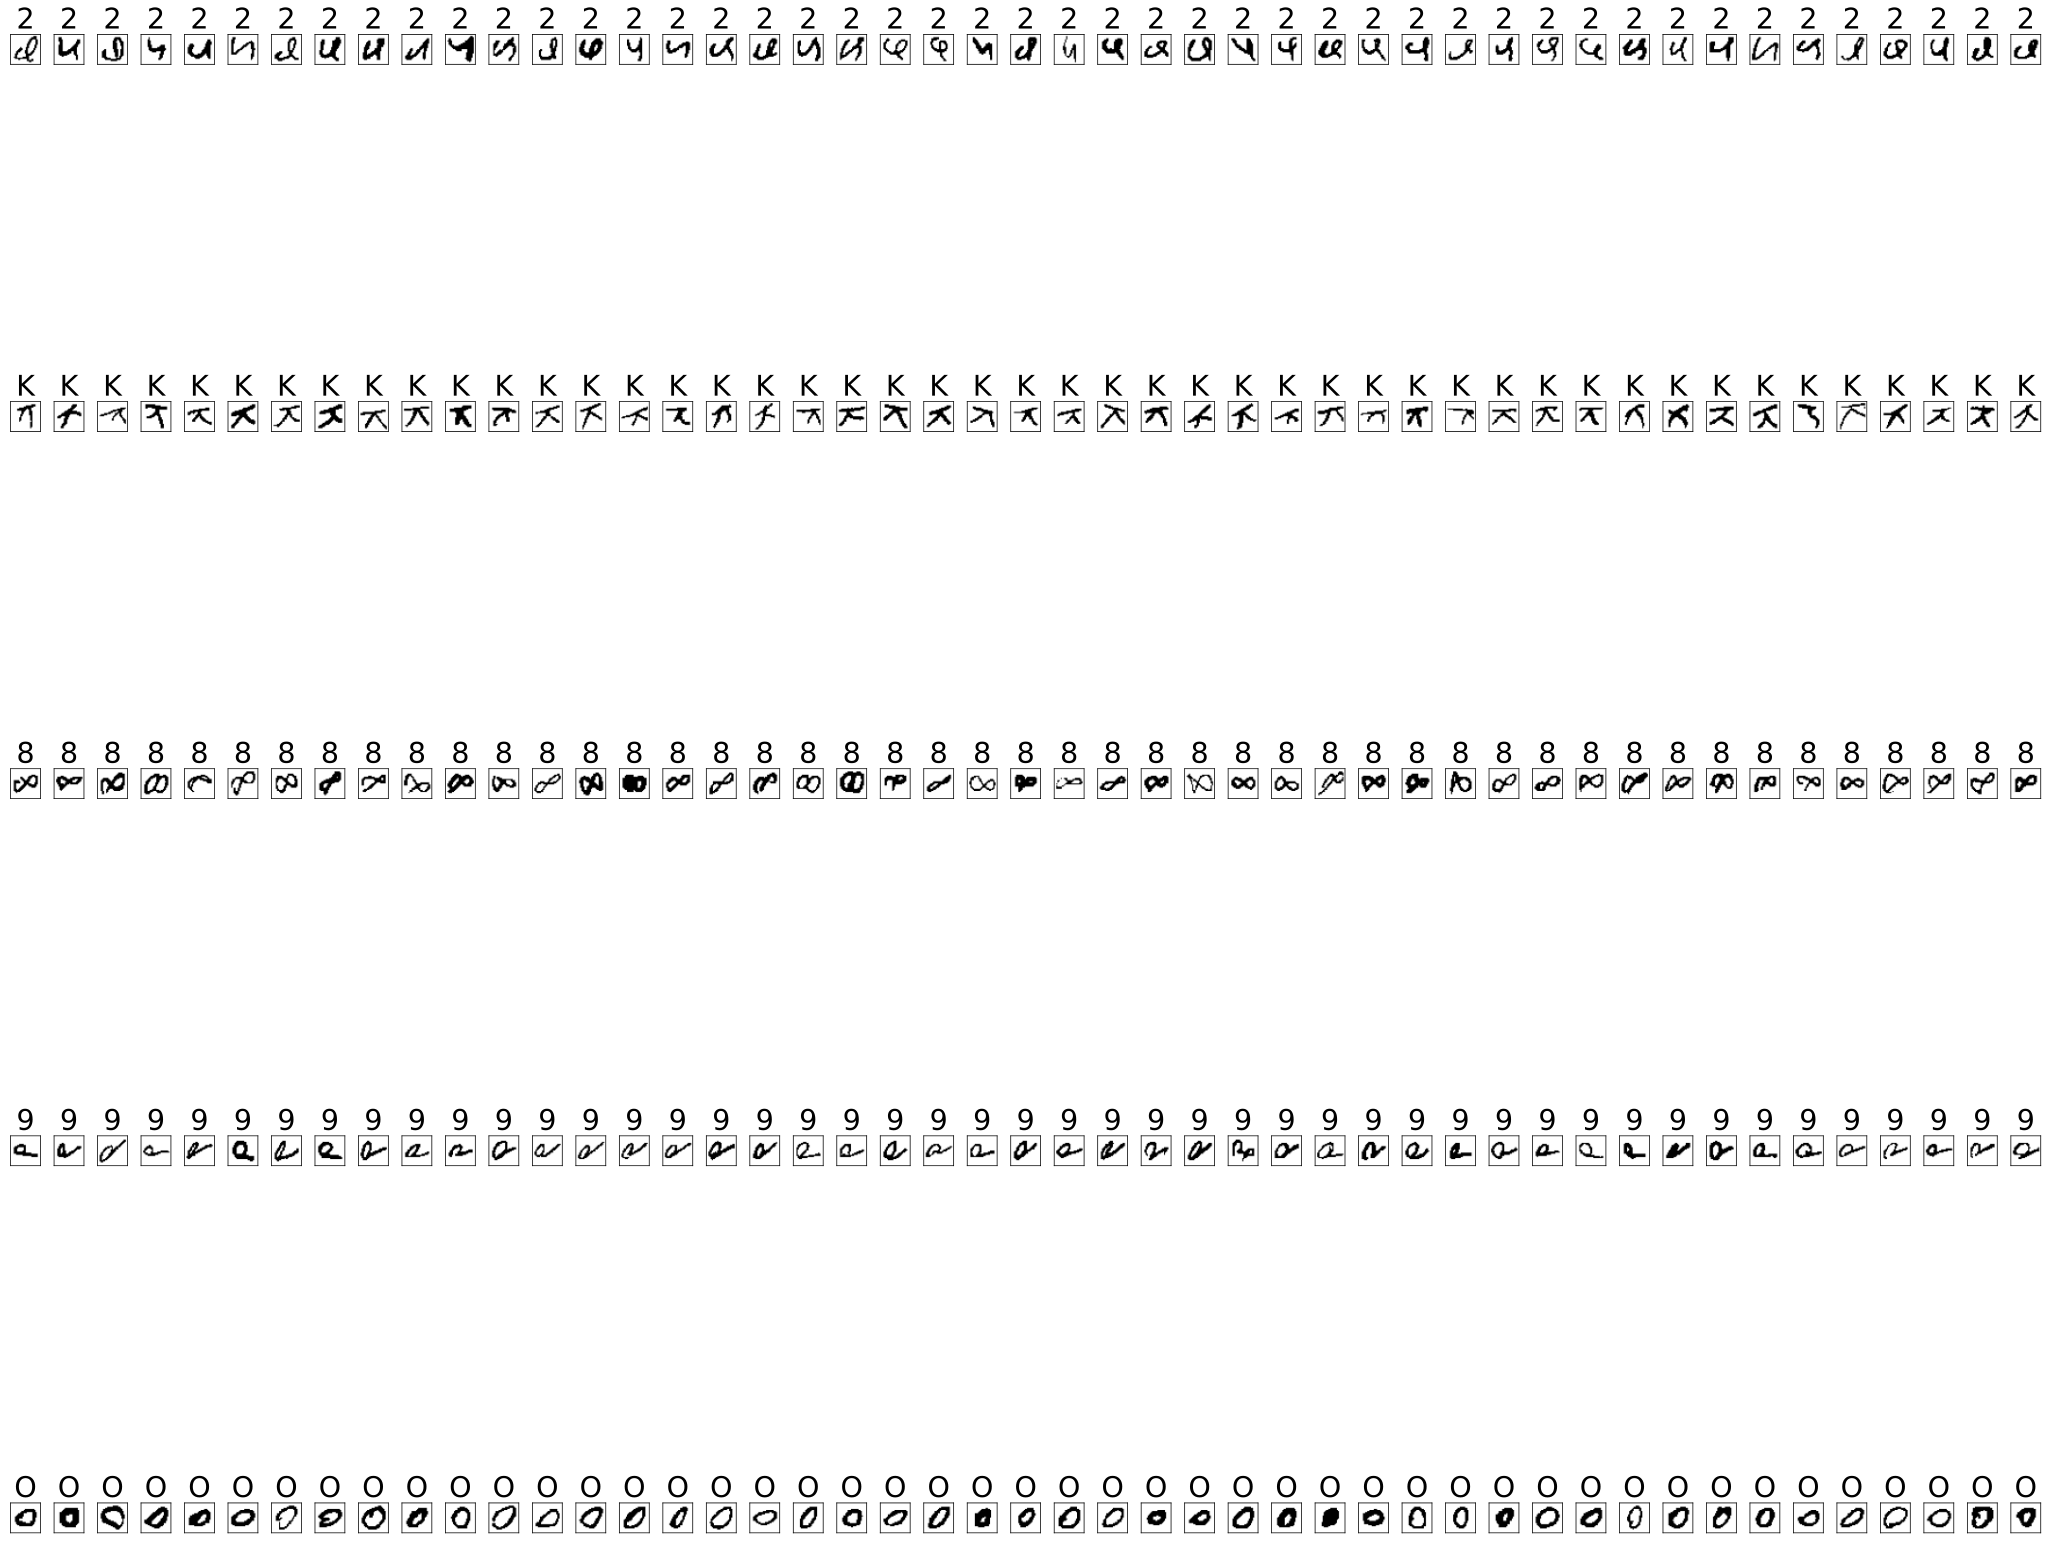

In [15]:
figure = plt.figure(figsize=(30, 30))
cols, rows = 47, 5
a = 0
lstLabel = []
lstIndex = []
while (a < 5):
    rd = random.randint(3, 10000)
    lab = data[rd][1]
    if not lab in lstLabel:
        lstLabel.append(lab)
        a += 1
    else:
        continue
for x in range(5):
    a = 0
    head = 0
    while a < 47:
        if (data[head][1] == lstLabel[x]):
            lstIndex.append(head)
            a += 1
        head += 1

for i in range(1, cols * rows + 1):
    sample_idx = lstIndex[i - 1]
    img, label = data[sample_idx]
    figure.add_subplot(rows, cols, i)
    label = data.classes[label]
    plt.title(label, fontsize=30)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img.squeeze(), cmap=plt.cm.binary)

plt.tight_layout()
plt.show()

In [20]:
from sklearn import datasets
from sklearn import naive_bayes
from sklearn.model_selection import train_test_split
import math
import torch
import torchvision
from d2l import torch as d2l
from sklearn.base import BaseEstimator, ClassifierMixin

d2l.use_svg_display()

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [118]:
class mleClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.P_y = torch.zeros(47)
        self.P_xy = torch.torch.zeros((47, 28, 28))

    def fit(self, X_train, Y_train):
        n_y = torch.zeros(47)
        for y in range(47):
            n_y[y] = (Y_train == y).sum()
        self.P_y = (n_y+1) / (n_y.sum()+47)

        n_x = torch.zeros((47, 28, 28))
        for y in range(47):
            n_x[y] = torch.tensor(X_train.numpy()[Y_train.numpy() == y].sum(axis=0))
        self.P_xy = (n_x+1) / (n_y.reshape(47, 1, 1)+2)

    def predict(self, X, y):
        log_P_xy = torch.log(self.P_xy)
        log_P_xy_neg = torch.log(1 - self.P_xy)
        log_P_y = torch.log(self.P_y)
        predicted=[]
        for x in X:
            x = x.unsqueeze(0)  # (28, 28) -> (1, 28, 28)
            p_xy = log_P_xy * x + log_P_xy_neg * (1 - x)
            p_xy = p_xy.reshape(47, -1).nansum(axis=1)  # p(x|y)
            res = p_xy + log_P_y
            predicted.append(res.argmax(dim=0))
        return predicted


    def score(self, X, y, sample_weight=None):
        log_P_xy = torch.log(self.P_xy)
        log_P_xy_neg = torch.log(1 - self.P_xy)
        log_P_y = torch.log(self.P_y)
        score = 0
        for i in range(len(y)):
            x = X[i].unsqueeze(0)  # (28, 28) -> (1, 28, 28)
            p_xy = log_P_xy * x + log_P_xy_neg * (1 - x)
            p_xy = p_xy.reshape(47, -1).nansum(axis=1)  # p(x|y)
            res = p_xy + log_P_y
            score += res[y[i]]
        return (score / len(y)).item()

In [119]:
mle = mleClassifier()
mle.fit(X_train, Y_train)
mlepredicted=mle.predict(X_test,Y_test)
print(mlepredicted)
print(mle.score(X_test,Y_test))

[tensor(35), tensor(28), tensor(32), tensor(1), tensor(39), tensor(32), tensor(3), tensor(10), tensor(33), tensor(44), tensor(19), tensor(1), tensor(24), tensor(8), tensor(44), tensor(22), tensor(6), tensor(23), tensor(1), tensor(2), tensor(0), tensor(11), tensor(22), tensor(24), tensor(22), tensor(43), tensor(23), tensor(35), tensor(18), tensor(8), tensor(29), tensor(15), tensor(27), tensor(4), tensor(9), tensor(31), tensor(10), tensor(44), tensor(45), tensor(36), tensor(15), tensor(23), tensor(35), tensor(32), tensor(44), tensor(36), tensor(1), tensor(39), tensor(45), tensor(40), tensor(12), tensor(44), tensor(9), tensor(17), tensor(16), tensor(18), tensor(31), tensor(31), tensor(33), tensor(23), tensor(22), tensor(35), tensor(38), tensor(31), tensor(25), tensor(18), tensor(24), tensor(13), tensor(35), tensor(46), tensor(13), tensor(6), tensor(22), tensor(9), tensor(24), tensor(39), tensor(19), tensor(32), tensor(13), tensor(17), tensor(38), tensor(5), tensor(11), tensor(11), tensor(

-229.53282165527344


In [151]:
class mapClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, alpha):
        self.P_y = torch.zeros(47)
        self.P_xy = torch.torch.zeros((47, 28, 28))
        self.alpha = alpha

    def fit(self, X_train, Y_train):
        n_y = torch.zeros(47)
        for y in range(47):
            n_y[y] = (Y_train == y).sum()
        self.P_y = (n_y + self.alpha - 1) / (n_y.sum() + self.alpha * 47 - 47)

        n_x = torch.zeros((47, 28, 28))
        for y in range(47):
            n_x[y] = torch.tensor(X_train.numpy()[Y_train.numpy() == y].sum(axis=0))
        self.P_xy = (n_x + self.alpha - 1) / (n_y + self.alpha * 2 - 2).reshape(47, 1, 1)

    def predict(self, X, y):
        log_P_xy = torch.log(self.P_xy)
        log_P_xy_neg = torch.log(1 - self.P_xy)
        log_P_y = torch.log(self.P_y)
        predicted=[]
        for x in X:
            x = x.unsqueeze(0)  # (28, 28) -> (1, 28, 28)
            p_xy = log_P_xy * x + log_P_xy_neg * (1 - x)
            p_xy = p_xy.reshape(47, -1).nansum(axis=1)  # p(x|y)
            res = p_xy + log_P_y
            predicted.append(res.argmax(dim=0))
        return predicted

    def score(self, X, y, sample_weight=None):
        log_P_xy = torch.log(self.P_xy)
        log_P_xy_neg = torch.log(1 - self.P_xy)
        log_P_y = torch.log(self.P_y)
        score = 0
        for i in range(len(y)):
            x = X[i].unsqueeze(0)  # (28, 28) -> (1, 28, 28)
            p_xy = log_P_xy * x + log_P_xy_neg * (1 - x)
            p_xy = p_xy.reshape(47, -1).nansum(axis=1)  # p(x|y)
            res = p_xy + log_P_y
            score += res[y[i]]
        return score / len(y)

In [121]:
Map = mapClassifier(50)
Map.fit(X_train, Y_train)
mappredicted=Map.predict(X_test,Y_test)
print(mappredicted)
print(Map.score(X_test,Y_test))

[tensor(35), tensor(28), tensor(32), tensor(1), tensor(39), tensor(46), tensor(3), tensor(10), tensor(33), tensor(4), tensor(19), tensor(1), tensor(24), tensor(8), tensor(44), tensor(22), tensor(6), tensor(23), tensor(1), tensor(2), tensor(0), tensor(11), tensor(22), tensor(24), tensor(22), tensor(43), tensor(23), tensor(35), tensor(18), tensor(8), tensor(29), tensor(29), tensor(27), tensor(4), tensor(9), tensor(31), tensor(10), tensor(44), tensor(45), tensor(36), tensor(15), tensor(23), tensor(35), tensor(32), tensor(18), tensor(36), tensor(1), tensor(39), tensor(45), tensor(40), tensor(12), tensor(44), tensor(9), tensor(17), tensor(16), tensor(18), tensor(31), tensor(31), tensor(33), tensor(23), tensor(22), tensor(35), tensor(38), tensor(31), tensor(25), tensor(18), tensor(24), tensor(13), tensor(35), tensor(46), tensor(13), tensor(6), tensor(22), tensor(9), tensor(24), tensor(39), tensor(19), tensor(32), tensor(13), tensor(17), tensor(38), tensor(5), tensor(11), tensor(11), tensor(3

tensor(-237.1193)


In [142]:
class BayesianClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, alpha):
        self.P_y = torch.zeros(47)
        self.P_xy = torch.torch.zeros((47, 28, 28))
        self.alpha = alpha

    def fit(self, X_train, Y_train):
        n_y = torch.zeros(47)
        for y in range(47):
            n_y[y] = (Y_train == y).sum()
        self.P_y = (n_y + self.alpha) / (n_y.sum() + self.alpha * 47)

        n_x = torch.zeros((47, 28, 28))
        for y in range(47):
            n_x[y] = torch.tensor(X_train.numpy()[Y_train.numpy() == y].sum(axis=0))
        self.P_xy = (n_x + self.alpha) / (n_y + self.alpha * 2).reshape(47, 1, 1)

    def predict(self, X, y):
        log_P_xy = torch.log(self.P_xy)
        log_P_xy_neg = torch.log(1 - self.P_xy)
        log_P_y = torch.log(self.P_y)
        predicted=[]
        for x in X:
            x = x.unsqueeze(0)  # (28, 28) -> (1, 28, 28)
            p_xy = log_P_xy * x + log_P_xy_neg * (1 - x)
            p_xy = p_xy.reshape(47, -1).nansum(axis=1)  # p(x|y)
            res = p_xy + log_P_y
            predicted.append(res.argmax(dim=0))
        return predicted

    def score(self, X, y, sample_weight=None):
        log_P_xy = torch.log(self.P_xy)
        log_P_xy_neg = torch.log(1 - self.P_xy)
        log_P_y = torch.log(self.P_y)
        score = 0
        for i in range(len(y)):
            x = X[i].unsqueeze(0)  # (28, 28) -> (1, 28, 28)
            p_xy = log_P_xy * x + log_P_xy_neg * (1 - x)
            p_xy = p_xy.reshape(47, -1).nansum(axis=1)  # p(x|y)
            res = p_xy + log_P_y
            score += res[y[i]]
        return score / len(y)

In [145]:
Bays = BayesianClassifier(10)
Bays.fit(X_train, Y_train)
bypredicted=Bays.predict(X_test,Y_test)
print(bypredicted)
print(Bays.score(X_test,Y_test))

[tensor(35), tensor(28), tensor(32), tensor(1), tensor(39), tensor(46), tensor(3), tensor(10), tensor(33), tensor(4), tensor(19), tensor(1), tensor(24), tensor(8), tensor(44), tensor(22), tensor(6), tensor(23), tensor(1), tensor(2), tensor(0), tensor(11), tensor(22), tensor(24), tensor(22), tensor(43), tensor(23), tensor(35), tensor(18), tensor(8), tensor(29), tensor(15), tensor(27), tensor(4), tensor(9), tensor(31), tensor(10), tensor(44), tensor(45), tensor(36), tensor(15), tensor(23), tensor(35), tensor(32), tensor(18), tensor(36), tensor(1), tensor(39), tensor(45), tensor(40), tensor(12), tensor(44), tensor(9), tensor(17), tensor(16), tensor(18), tensor(31), tensor(31), tensor(33), tensor(23), tensor(22), tensor(35), tensor(38), tensor(31), tensor(25), tensor(18), tensor(24), tensor(13), tensor(35), tensor(46), tensor(13), tensor(6), tensor(22), tensor(9), tensor(24), tensor(39), tensor(19), tensor(32), tensor(13), tensor(17), tensor(38), tensor(5), tensor(11), tensor(11), tensor(3

tensor(-230.7623)


In [56]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

In [134]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                            n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,train_sizes=train_sizes, return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.title(title)
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    plt.show()

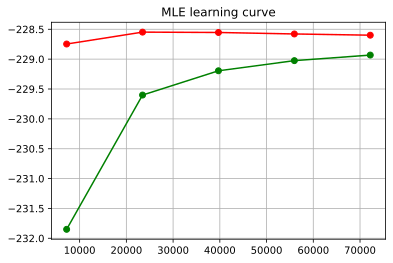

In [117]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = mleClassifier()
estimator.fit(X_train,Y_train)
title = "MLE learning curve"
plot_learning_curve(estimator, title, X_train, Y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=-1)

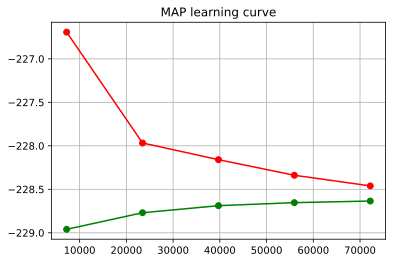

In [150]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = mapClassifier(1)
estimator.fit(X_train,Y_train)
title = "MAP learning curve"
plot_learning_curve(estimator, title, X_train, Y_train, (0.7, 1.01), cv=cv, n_jobs=-1)

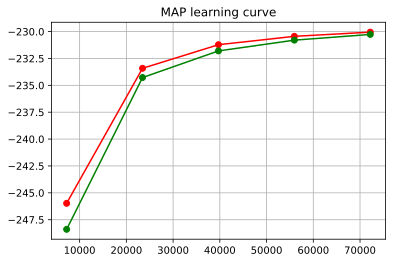

In [147]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = mapClassifier(10)
estimator.fit(X_train,Y_train)
title = "MAP learning curve"
plot_learning_curve(estimator, title, X_train, Y_train, (0.7, 1.01), cv=cv, n_jobs=-1)

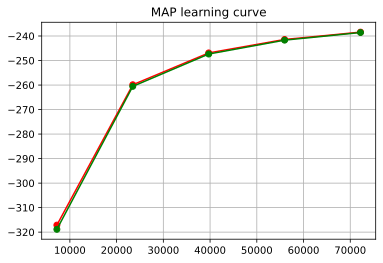

In [152]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = mapClassifier(50)
estimator.fit(X_train,Y_train)
title = "MAP learning curve"
plot_learning_curve(estimator, title, X_train, Y_train, (0.7, 1.01), cv=cv, n_jobs=-1)

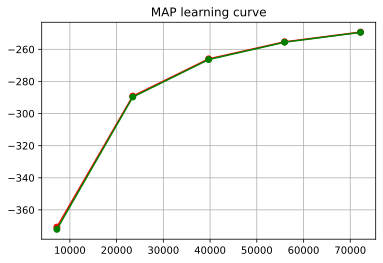

In [153]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = mapClassifier(100)
estimator.fit(X_train,Y_train)
title = "MAP learning curve"
plot_learning_curve(estimator, title, X_train, Y_train, (0.7, 1.01), cv=cv, n_jobs=-1)

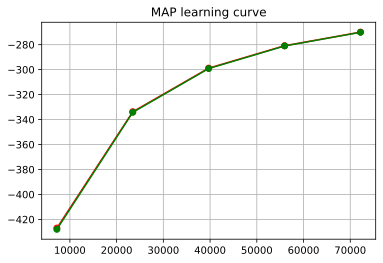

In [154]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = mapClassifier(200)
estimator.fit(X_train,Y_train)
title = "MAP learning curve"
plot_learning_curve(estimator, title, X_train, Y_train, (0.7, 1.01), cv=cv, n_jobs=-1)

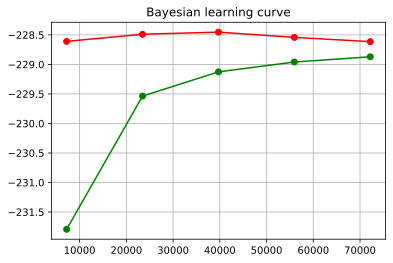

In [155]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = BayesianClassifier(1)
estimator.fit(X_train,Y_train)
title = "Bayesian learning curve"
plot_learning_curve(estimator, title, X_train, Y_train, (0.7, 1.01), cv=cv, n_jobs=-1)

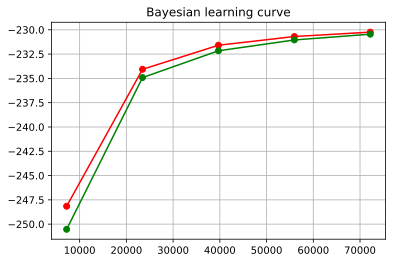

In [146]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = BayesianClassifier(10)
estimator.fit(X_train,Y_train)
title = "Bayesian learning curve"
plot_learning_curve(estimator, title, X_train, Y_train, (0.7, 1.01), cv=cv, n_jobs=-1)

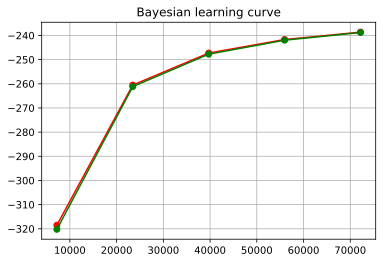

In [156]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = BayesianClassifier(50)
estimator.fit(X_train,Y_train)
title = "Bayesian learning curve"
plot_learning_curve(estimator, title, X_train, Y_train, (0.7, 1.01), cv=cv, n_jobs=-1)

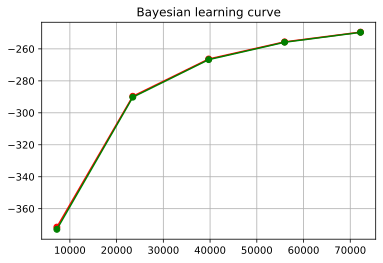

In [157]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = BayesianClassifier(100)
estimator.fit(X_train,Y_train)
title = "Bayesian learning curve"
plot_learning_curve(estimator, title, X_train, Y_train, (0.7, 1.01), cv=cv, n_jobs=-1)

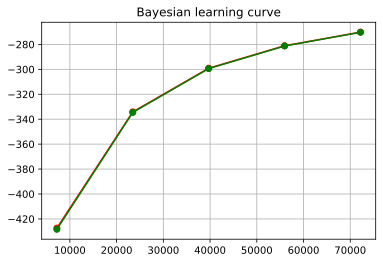

In [158]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = BayesianClassifier(200)
estimator.fit(X_train,Y_train)
title = "Bayesian learning curve"
plot_learning_curve(estimator, title, X_train, Y_train, (0.7, 1.01), cv=cv, n_jobs=-1)